# Session 1
## Implementing a 2D simulation of Active Brownian Particles (ABP) in Python.

### Overview of the problem

#### Description of the model

Let us consider a two-dimensional system consisting of $N$ identical disks of radius $a$. The instantaneous position of disk $i$ is given by the radius vector $\mathbf{r}_i = x_i\mathbf{e}_x+y_i\mathbf{e}_y$. In addition, each disk is polar and its polarity is described by a vector $\mathbf{n}_i = \cos(\vartheta_i)\mathbf{e}_x + \sin(\vartheta_i)\mathbf{e}_y$, where $\vartheta_i$ is angle between $\mathbf{n}_i$ and the $x-$axis of the laboratory reference frame. It is immediately clear that $\left|\mathbf{n}_i\right| = 1$.

Disks are assumed to be soft, i.e., they repel each other if they overlap. The interaction force is therefore short-range and, for simplicity, we assume it to be harmonic, i.e., the force between disks $i$ and $j$ is
\begin{equation}
\mathbf{F}_{ij} = 
\begin{cases} 
    -k\left(2a - r_{ij}\right)\hat{\mathbf{r}}_{ij} & \text{if } r_{ij} \le 2a \\ 
    0 & \text{otherwise}
\end{cases},\tag{1}\label{eq:force}
\end{equation}
where $k$ is the spring stiffness constant, $\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j$, $r_{ij} = \left|\mathbf{r}_{ij}\right|$ is the distance between particles $i$ and $j$ and $\hat{\mathbf{r}}_{ij} = \frac{\mathbf{r}_{ij}}{r_{ij}}$. Furthermore, overlapping disk are assumed to experience torque that acts to align their polarities. Torque on disk $i$ due to disk $j$ is 
\begin{equation}
\boldsymbol{\tau}_{ij} = 
\begin{cases} 
    -J\mathbf{n}_i\times\mathbf{n}_j & \text{if } r_{ij} \le 2a \\ 
    0 & \text{otherwise}
\end{cases}\tag{2}\label{eq:torque},
\end{equation}
where $J$ is the alignment strength. Note that since we are working in two dimensions, $\boldsymbol{\tau}_{ij} = \tau_{ij}\mathbf{e}_z$. It is easy to show that $\tau_{ij} = J\sin\left(\vartheta_i-\vartheta_j\right)$. Finally, each disk is self-propelled along the direction of its vector with a force 
\begin{equation}
\mathbf{F}_i = \alpha \mathbf{n}_i,\tag{3}\label{eq:spforce}
\end{equation}
where $\alpha$ is the magnitude of the self-propulsion force.

Key ingredients of the model are show in the figure below:
<div align="center">
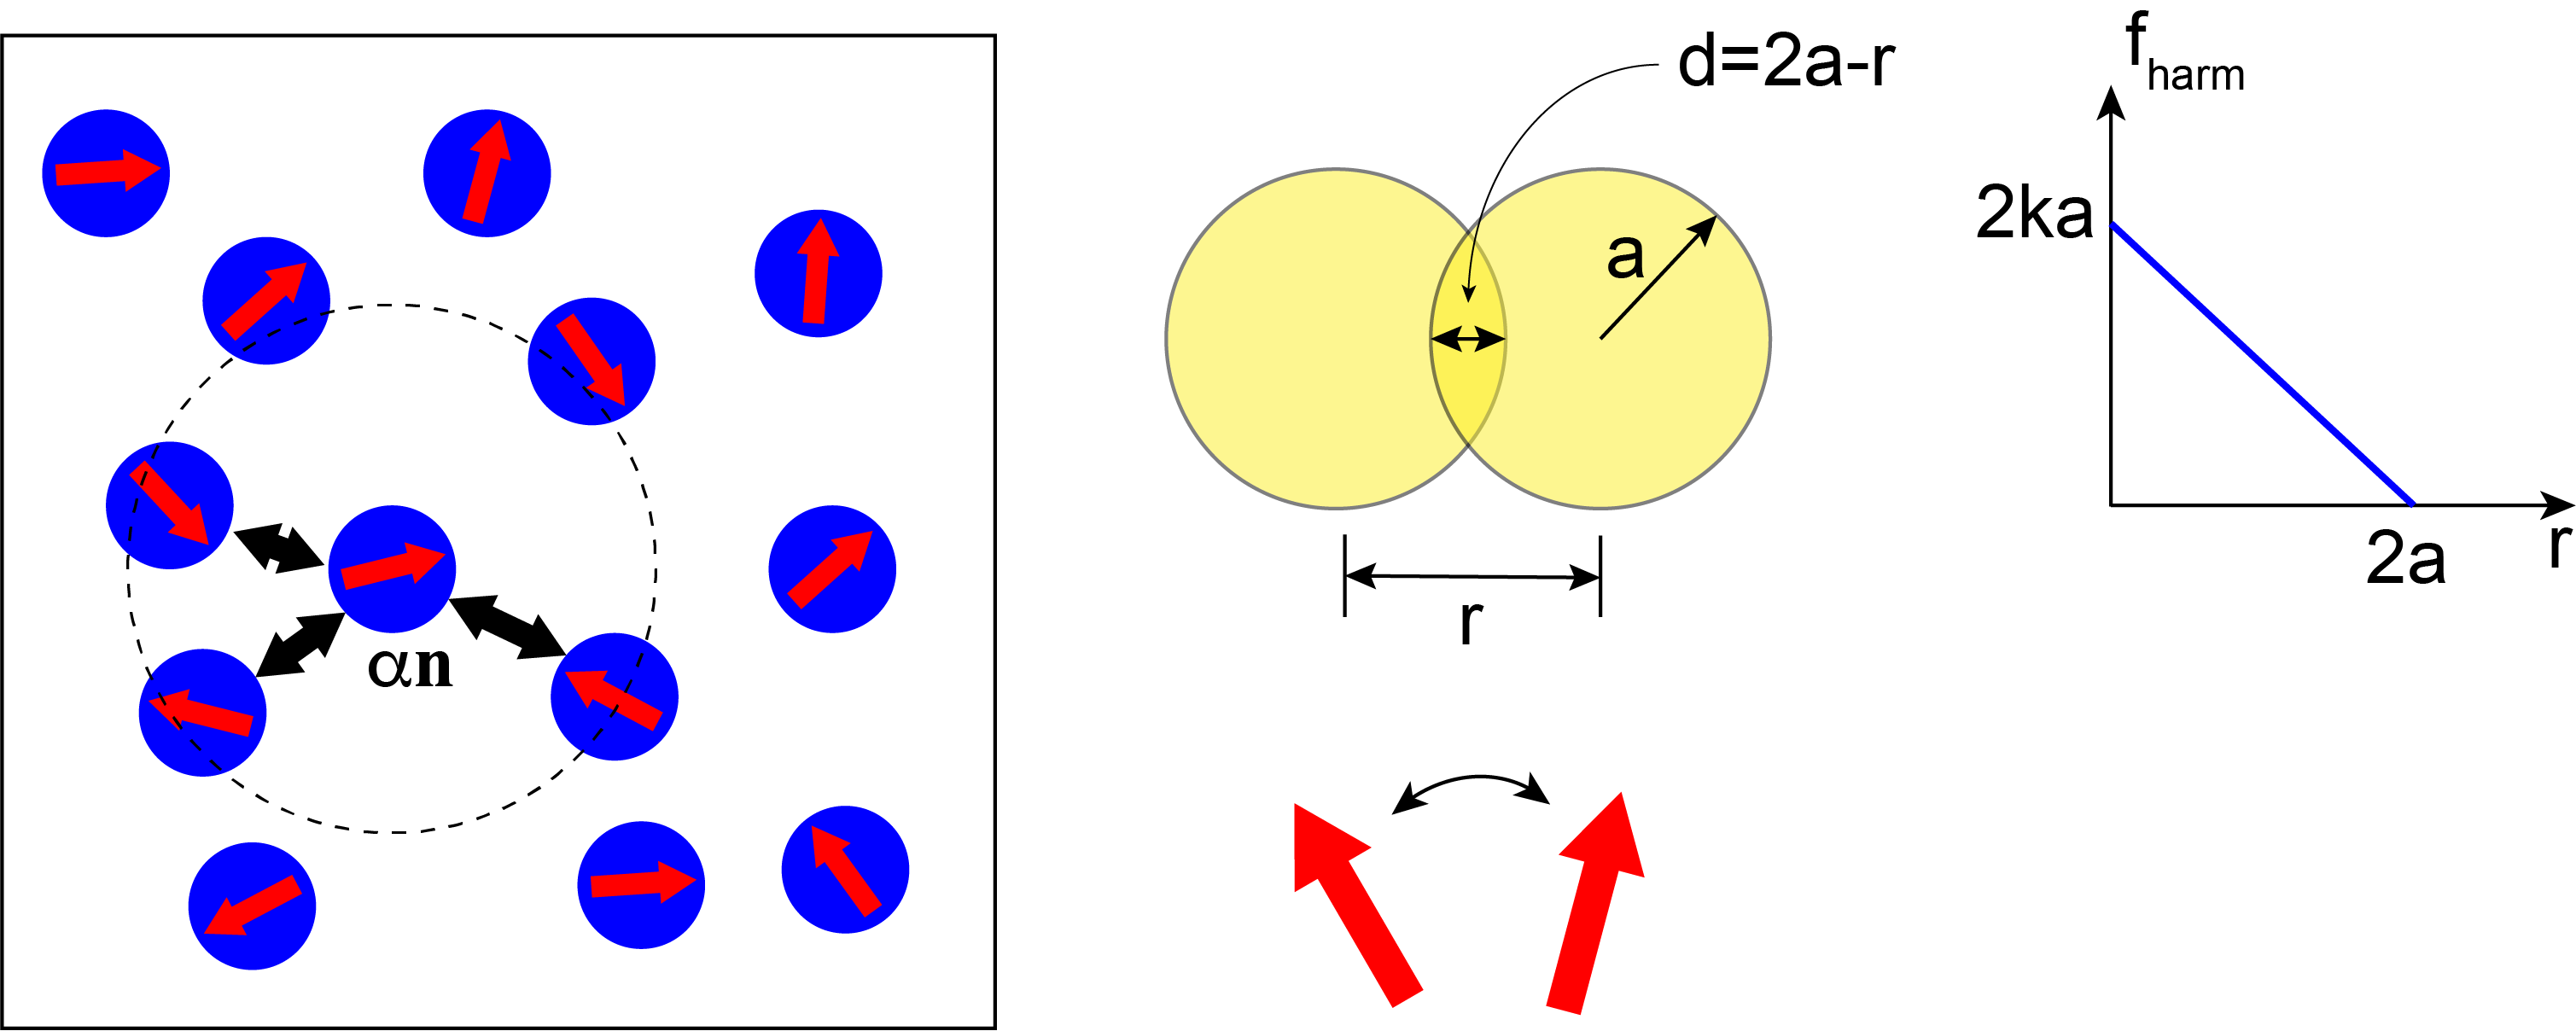
</div>


#### Equations of motion
    
In the overdamped limit, all inertial effects are neglected and the equations of motion become simply force (and torque) balance equations. For the model defined above we have,
\begin{eqnarray}
    \dot{\mathbf{r}}_i & = & v_0 \mathbf{n}_i + \frac{1}{\gamma_t}\sum_j \mathbf{F}_{ij} + \boldsymbol{\xi}^{t}_{i}\tag{4}\\
    \dot{\vartheta}_i & = & \frac{1}{\tau_r}\sin\left(\vartheta_i-\vartheta_j\right) + \xi_i^r.\tag{5}\label{eq:motion_theta}
\end{eqnarray}
In previous equations we introduced translational and rotational friction coefficients, $\gamma_t$ and $\gamma_r$, respectively and defined $v_0 = \frac{\alpha}{\gamma_t}$ and $\tau_r = \frac{\gamma_r}{J}$. Note that $v_0$ has units of velocity (hence we interpret it as the self-propulsion speed) while $\tau_r$ has units of time (hence we interpret it as the polarity alignment time scale). $\boldsymbol{\xi}_i^t$ is the white noise, which we here assume to be thermal noise (in general, this assumption is not required for a system out of equilibrium), i.e., $\langle\xi_{i,\alpha}\rangle=0$ and $\langle \xi_{i,\alpha}^t(t)\xi_{j,\beta}^t(t^\prime)\rangle = 2\frac{k_BT}{\gamma_t}\delta_{ij}\delta_{\alpha\beta}\delta(t-t^\prime)$, with $\alpha, \beta \in \{x, y\}$ and $T$ being temperature. Similarly, $\xi_i^r$ is the rotational noise, with $\langle\xi_i^r\rangle = 0$ and $\langle \xi_i^r(t)\xi_j^r(t^\prime)\rangle = 2D_r\delta_{ij}\delta(t-t^\prime)$, where we have introduced the rotational diffusion coefficient $D_r$.


<div align="center">
<font size="5" color="#990000"><b>The purpose of this tutorial is to develop a computer code that solves these equations of motion.</b></font>
</div>


**Note** In this session we will sacrifice performance for clarity. Codes presented here are not optimized and quite often the implementation is very inefficient. This has been done deliberately in order not to obfuscate the key concepts. 

Our design philosophy, however, is to split the problem into a set of loosely coupled modules. This makes testing and maintenance simple.


### Overview of a particle-based simulation

A typical particle-based simulation consists of three steps:

1. Creating the initial configuration 
2. Executing the simulation 
3. Analyzing the results

The standard workflow is: step 1 feeds into step 2, which, in turn feeds into step 3. 

Depending on the approach and the problem at hand, sometimes these three steps are done by the same code. In line with our key design philosophy to keep things as detached from each other as possible, in this tutorial we treat these two steps as independent. The communication between steps will be based on a shared file format, i.e., code written for the step 1 will produce output files in a format that the code in step 2 can directly read, etc.

#### Creating the initial configuration

In the first step we first need to generate the system we would like to study, i.e. we need to create the initial configuration for our simulation. Sometimes, as this will be the case here, this is a fairly simple task. However, creating the proper initial configuration can also be a challenging task in its own right that requires a set of sophisticated tools to do. A good example would be setting up a simulation of several complex biomolecules.

Regardless of the complexity, typically the result of this step is one (or several) text (sometimes binary) files that contain information such as the size of the simulation box, initial positions and velocities of all particles, particle connectivity, etc.

In this tutorial, we will use a set of simple Python scripts (located in *Python/pymd/builder* directory) to create the initial configuration that will be saved as JSON file.

For example, let us build the initial configuration with a square simulation box of size $L=50$ with the particle number density $\phi=\frac{N}{L^2}=0.4$. We also make sure that centers of no two particles less than $a=1$ apart. (**Note:** Neither $L$ not $a$ have units here. We'll get back to the issue of simulation units below.)


In [6]:
from pymd.builder import *
phi = 0.4
L = 50
a = 1.0
random_init(phi, L, rcut=a, outfile='init.json')  

A simple inspection of the file *init.json* confirms that $N=1000$ particles have been created in the simulation box of size $50\times50$.

**Note:** In this tutorial we will aways assume the simulation box is orthogonal and centered at $(0,0)$. In other words, for simulation box of size $L_x=50$, $L_y=40$, all particles are located in the rectangle with corners at $(-25,-20)$, $(25,-20)$, $(25,20)$, $(-25,20)$.

#### Executing the simulation 

This step is the focus of this tutorial. Conceptually, this step is straightforward - we need to write a program that solve the equations for motion for a collection of $N$ particles placed in the simulation box in the step 1. In practice, this is technically the most challenging step and some of the most advanced particle based codes can contain hundreds of thousands of lines of code. 

The problem is that equations of motions are couples, i.e., we are tasked with solving the N-body problem. Therefore, any naive implementation would be so slow that it would not be possible to simulate even the simplest systems within any reasonable time. For this reason, even the most basic particle based codes have to implement several algorithms that make the problem tractable. Furthermore, any slightly more complex problem would require parallelization, which is the topic of the last session in this tutorial. 

#### Analyzing the results

Once the simulation in the step 2 has been completed, we need to perform a series of measurements to extract as much physical information about our system as possible. Although sometimes some basic analysis can be done by the main simulation code in step 2, this is typically done a posteriori with a separate set of tools. Technically speaking, the main simulation code produces a file (or a set of files), often referred to as *trajectories*, that are loaded into the analysis code for post-processing. 

One of the key steps in the post-processing stage is visualization, e.g. making a movie of the time evolution of the system. Therefore, most simulation codes are able to output the data in multiple file formats for various types of post-processing analysis.

In this tutorial we will output the data in JSON and VTP formats. VTP files can be directly visualized with the powerful Paraview software package. 


**Note:** There are many excellent codes that perform step 2. For example, GROMACS, LAMMPS, HOOMD Blue, ESPResSo, AMBER, DLPOLY, to name a few. Our aim is not to replace any of those codes but to showcase in a simple example what these codes do.


### Writing a particle based simulation in Python

Here we outline the key parts of a modern implementation of a particle-based simulation. We use Python for its simple syntax and powerful data structures.

#### Periodic boundary conditions

Before we dive deep into the inner workings of a particle-based code, let us quickly discuss the use of periodic boundary conditions (PBC). 

Even the most advanced particle-based simulations can simulate no more than several million particles. Most simulations are far more modest in size. A typical experimental system usually contains far more particles than it would be possible to simulate. Therefore, most simulations study a small section of an actual system and extrapolate the results onto the experimentally relevant scales. It is, therefore, important to minimize the finite size effects. One such approach is to use the  periodic boundary conditions.

The idea behind PBC is that the simulation box is assumed to have the topology of a torus. That is, a particle that leaves the simulation box through the left boundary would instantaneously reappear on the right side of the simulation box. This implies that when computing the distance between two particles one has to consider all of their periodic images as pick the shortest distance. This is called the *minimum image convention*.

The idea behind the minimum image convention is shown in the image below.

<div align="center">
    
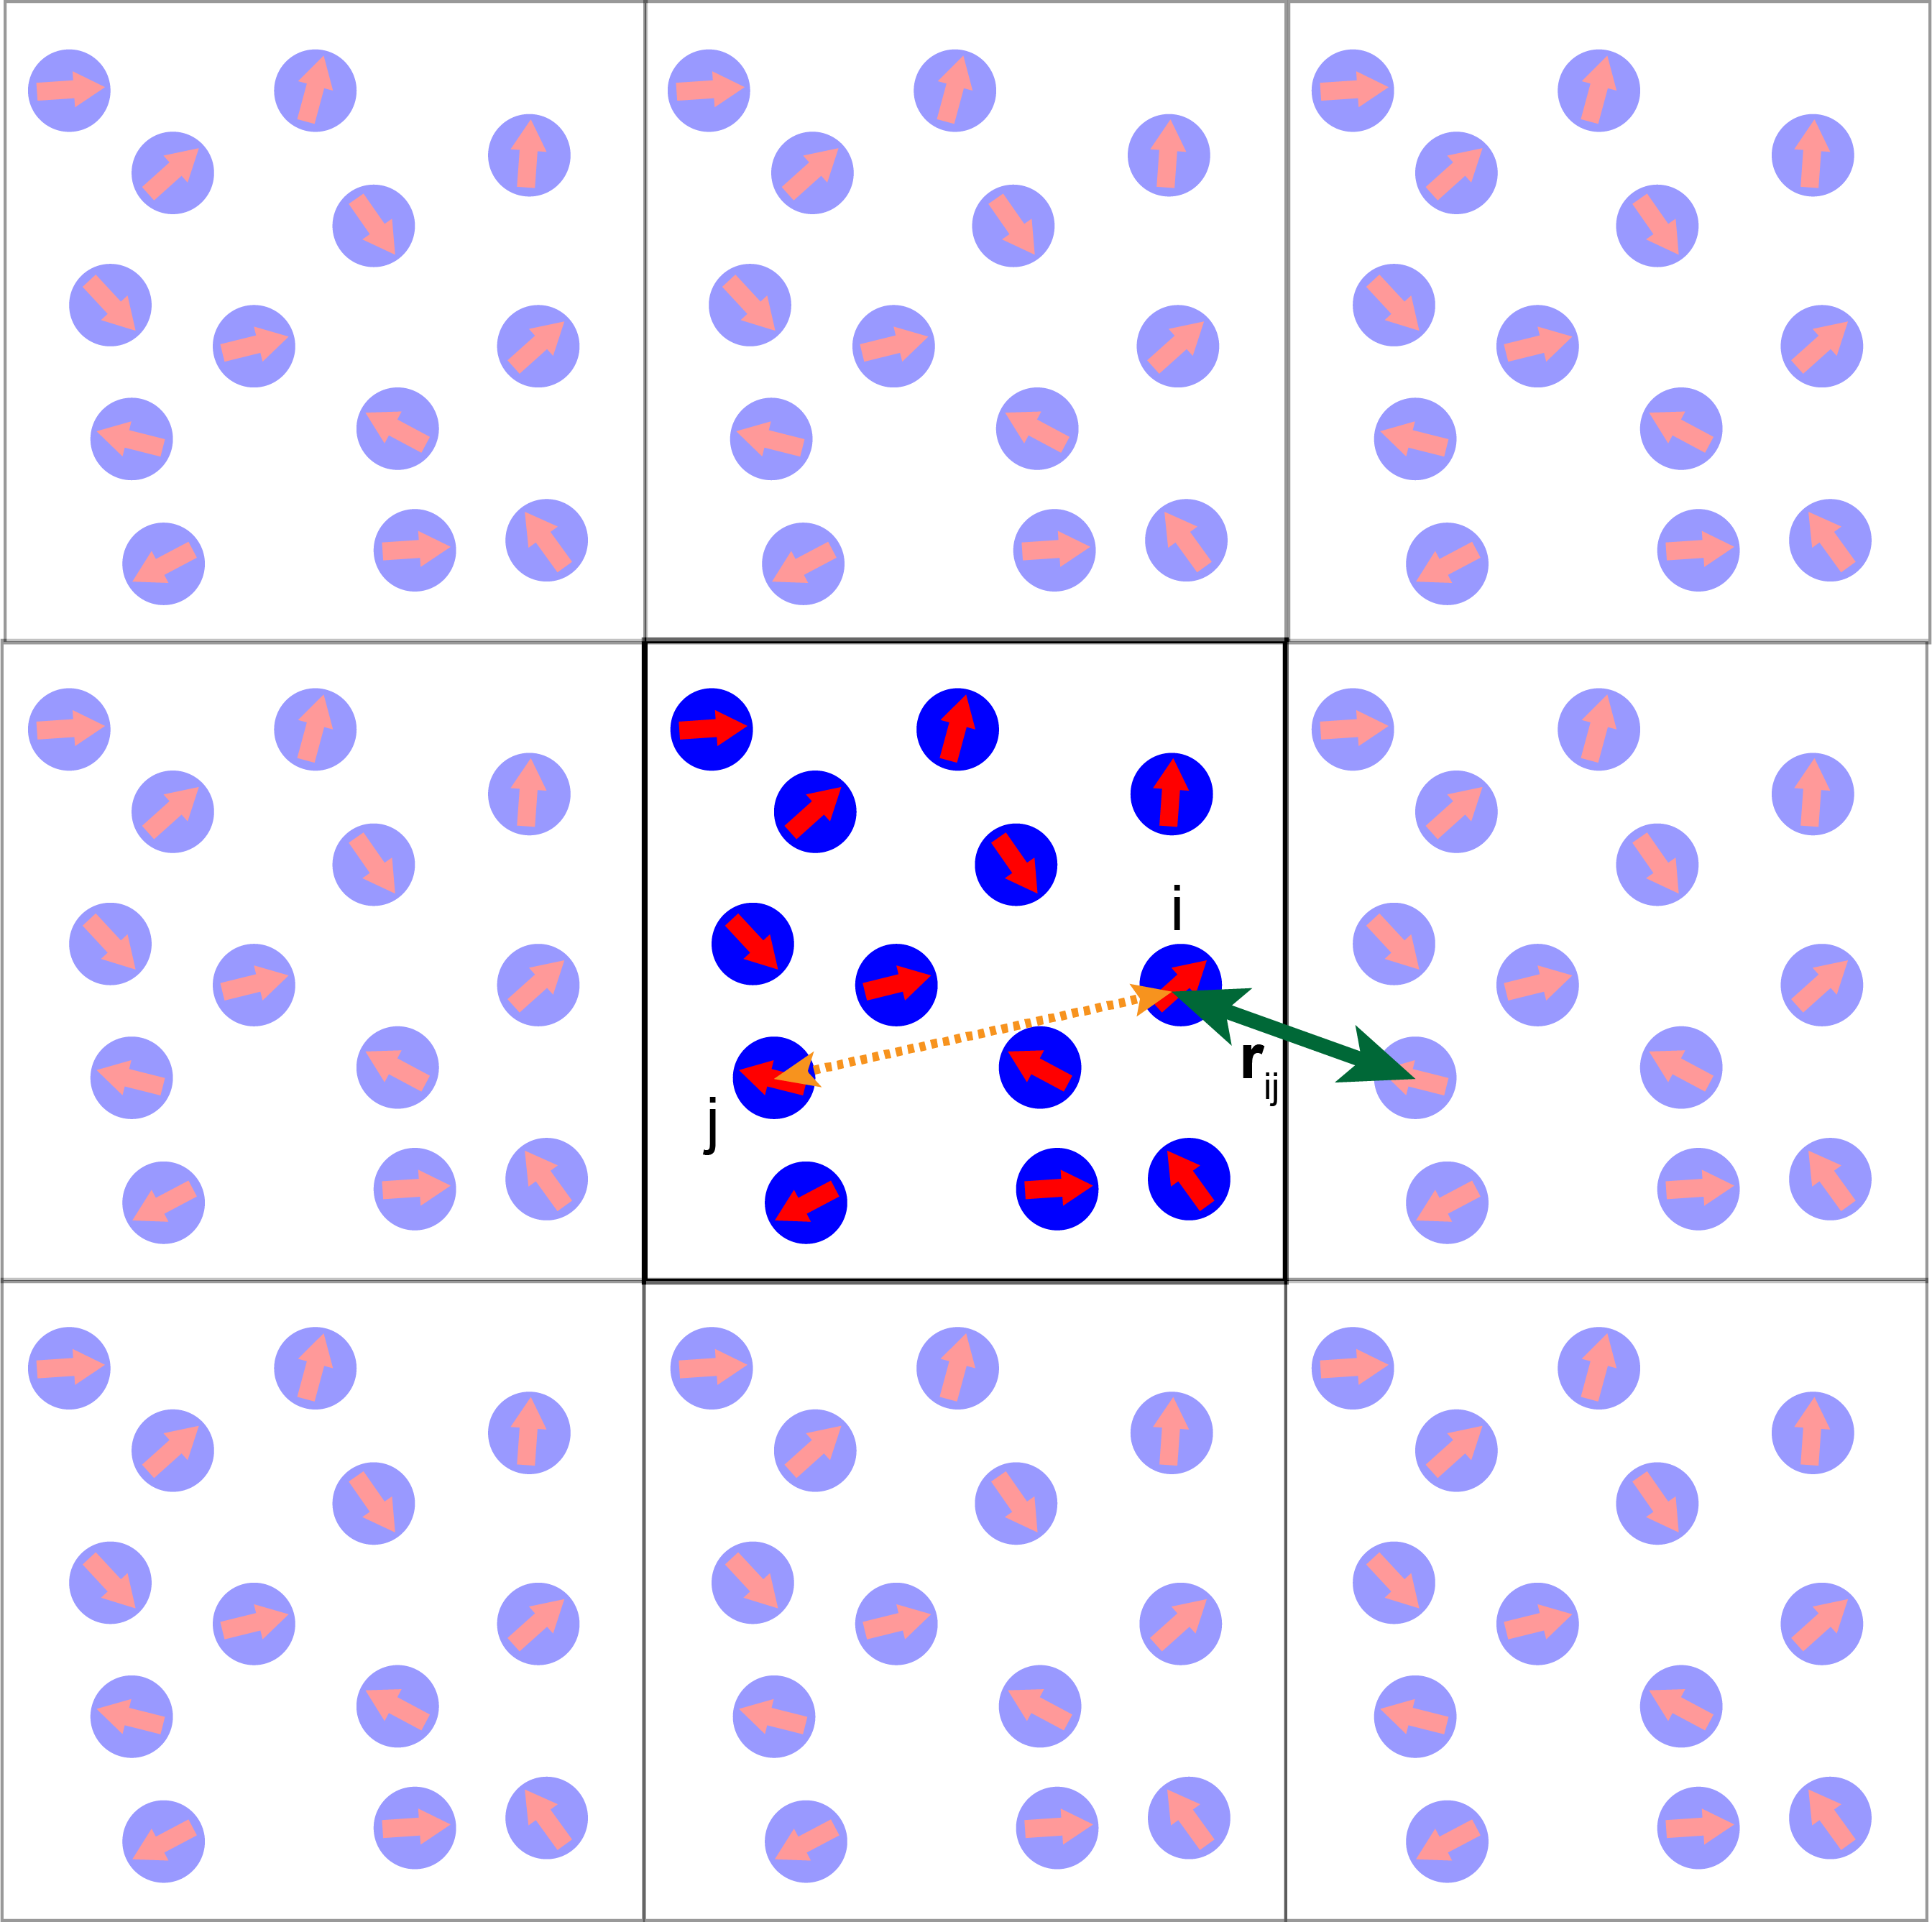
</div>

#### Key components of a particle-based simulation code

Here we discuss how things are organized 

### Python implementation 

### Putting it all together

Here is an overview of how things are organized

### Running a simulation 

Each simulation has three steps:

1. Building the initial configuration 
2. Running the simulation 
3. Analyzing results 

#### Building the initial configuration

#### Running the simulation 

#### Analyzing results

### Visualizing results

Here we talk about making movies